<a href="https://colab.research.google.com/github/soyounson/TIL-NLP/blob/main/Ch06_01_GP_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Process Regression

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Data 생성 및 확인

In [ ]:
np.random.seed(0)

def f(x):
    return np.sin(3*x)

In [ ]:
X = np.random.uniform(0, 5, 20)    # uniform(x,y, z) x,y범위내 랜덤 생성된 난수 z개 리턴
X_ = X.reshape(-1, 1) #한 개의 차원 늘리기

y = f(X.T) + np.random.normal(0, 0.1, X.shape[0]) # normal(mean, std, size=None), add noise
y_ = y.reshape(-1, 1)

X_test = np.linspace(-2, 7, 100)
X_test_ = X_test.reshape(-1, 1)

In [ ]:
print(X.shape, X_.shape)
print(y.shape, y_.shape)
print(X_test.shape, X_test_.shape)

(20,) (20, 1)
(20,) (20, 1)
(100,) (100, 1)


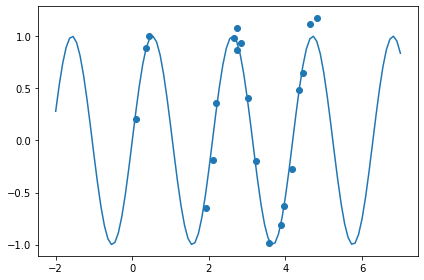

In [ ]:
def show_result(X, y,  X_plot, y_plot):
    plt.figure()
    plt.plot(X_plot, y_plot)
    plt.scatter(X, y, marker='o')
    plt.tight_layout()
    plt.show()
show_result(X, y, X_test, f(X_test))

# Kernel
## Radial Basis Function (RBF)

Using it as a kernel function.

$$ K(x, x') = exp(-\gamma \parallel x-x' \parallel^2) = exp(-\frac{|| x - x' ||^2}{2*\sigma^2} ) $$

We add and change some hyper parameters,

$$ K(x, x') = \sigma_f * exp(-\frac{|| x - x' ||^2}{2*l^2} ) $$

In [ ]:
def rbf(i, j, sigma_f=1, length_scale=1):
    
    return sigma_f*np.exp(-np.linalg.norm(i-j)**2/(2*length_scale**2))

# GPR Algorithm 

## Algorithm Outline

**Input**: Training dataset $\mathcal{D} = \{(\mathbf{x}_n, y_n) \ | \ n = 1, . . . , N\}$, test input $\mathbf{x}_∗$, covariance function $k(·, ·)$, and noise level $σ^2$

1. $\mathbf{K}_* =$ $[k(\mathbf{x}_i, \mathbf{x}_j)]_{ij} $
2. $\mathbf{k}_∗ =$ $[k(\mathbf{x}_1, \mathbf{x}_∗)$$,\dots$$, k(\mathbf{x}_N , \mathbf{x}_∗)]^T$
3. $\mathbf{L} =$ Cholesky$(\mathbf{K}+\sigma^2I)$
4. $\alpha =$ $\mathbf{L}^T \backslash (\mathbf{L} \backslash y)=$ $\mathbf{L}^{-T} \mathbf{L}^{-1} \mathbf{y}$
5. Predictive mean: $\mathbb{E}[f_∗] =$ $\mathbf{k}_*^T α$
6. $\mathbf{v} =$ $\mathbf{L} \backslash k_∗ =$ $\mathbf{L}^{-1} \mathbf{k}_*$
7. Predictive variance: var$(f_∗) =$ $k(\mathbf{x}_∗, \mathbf{x}_∗)-\mathbf{v}^T\mathbf{v}$
8. Marginal log-likelihood: $\log p(\mathbf{y}|\mathbf{X}) =$ 
$−\frac{1}{2} \mathbf{y}^T\alpha$ 
$−\Sigma_n \log \mathbf{L}_{n,n}$ 
$−\frac{N}{2} \log 2\pi$

**return** $\mathbb{E}[f_∗],$ var$(f_∗),$ $\log p(\mathbf{y}|\mathbf{X})$

### Hyper parameter

In [ ]:
sigma = .1
sigma_f = 1
length_scale = 1

In [ ]:
data, target, test = X_, y_, X_test_

# number of data
print('data.shape: {}'.format(data.shape))
N = data.shape[0]

# train-train data kernel matrix
K = [[rbf(i, j, sigma_f=sigma_f, length_scale=length_scale) 
      for j in data] 
     for i in data]
print('K.shape: {}'.format(np.array(K).shape))
K_ = np.array(K) + np.eye(N)*sigma**2           # np.eye는 단위행렬을 만들어주는 행렬
print('K_.shape: {}'.format(np.array(K_).shape))

# train-test data kernel matrix
k = [[rbf(i, j) for i in test] for j in data]
print('k.shape: {}'.format(np.array(k).shape))

# cholesky decomposition
L = np.linalg.cholesky(K_)
print('cholesky(K_).shape: {}'.format(np.array(L).shape))

# alpha
alpha = np.linalg.inv(L.T) @ (np.linalg.inv(L) @ target)   # linalg.inv --역행렬 함수
print('alpha.shape: {}'.format(np.array(alpha).shape))     # @: dot product

data.shape: (20, 1)
K.shape: (20, 20)
K_.shape: (20, 20)
k.shape: (20, 100)
cholesky(K_).shape: (20, 20)
alpha.shape: (20, 1)


In [ ]:
# mean   
E_f = np.transpose(k) @ alpha           #@는 벡터 연산
print('E[f].shape: {}'.format(np.array(E_f).shape))

# var
v = np.linalg.inv(L) @ k
Var_f = [[rbf(i,j) for i in test] for j in test] - (v.T @ v)
print('Var(f).shape: {}'.format(np.array(Var_f).shape))

# log-likelihood
log_L = - (target.T @ alpha)/2 \
        - np.sum(np.log(np.diag(L))) \
        - N*np.log(2*np.pi)/2
log_L = log_L.reshape([])

# '\'는 한 칸밑에서 이어 나가겠다는 파이썬 기호
print('log(L).shape: {}'.format(log_L.shape))

y_mean, y_cov, log_L = E_f, Var_f, log_L

E[f].shape: (100, 1)
Var(f).shape: (100, 100)
log(L).shape: ()


In [ ]:
# GPR 함수 만들기 

def GPR(data, target, test, sigma=1, sigma_f=1, length_scale=1):
    # number of data
    N = data.shape[0]
    # train-train data kernel matrix
    K = [[rbf(i, j, sigma_f=sigma_f, length_scale=length_scale) 
          for j in data] 
         for i in data]
    K_ = np.array(K) + np.eye(N)*sigma**2
    # train-test data kernel matrix
    k = [[rbf(i, j) for i in test] for j in data]
    
    # cholesky decomposition
    L = np.linalg.cholesky(K_)

    alpha = np.linalg.inv(L.T) @ (np.linalg.inv(L) @ target) #linalg.inv 역행렬

    E_f = np.transpose(k) @ alpha
    
    v = np.linalg.inv(L) @ k
    Var_f = [[rbf(i,j) for i in test] for j in test] - (v.T @ v)
    
    log_L = - (target.T @ alpha)/2 \
            - np.sum(np.log(np.diag(L))) \
            - N*np.log(2*np.pi)/2
    log_L = log_L.reshape([])
    
    return E_f, Var_f, log_L

In [ ]:
y_mean, y_cov, log_L = GPR(X_,y_,X_test_, 
                           sigma=sigma, sigma_f=sigma_f, 
                           length_scale=length_scale)
print(y_mean.shape)
print(y_cov.shape)
print(log_L.shape)

(100, 1)
(100, 100)
()


# Result Graph

In [ ]:
def show_gp_result(X, y, X_plot, y_plot, y_std, title):
    plt.figure(figsize=(10, 5))
    plt.plot(X_plot, y_plot, 'k', lw=3, zorder=9) # lw: 선굵기, zorder: 레이어 순서
    plt.fill_between(X_plot, 
                     y_plot - y_std,
                     y_plot + y_std,
                     alpha=0.5, color='k')
    plt.plot(X_plot, f(X_plot), 'r', lw=3, zorder=9)
    plt.scatter(X, y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))  # c: color s: 마커크기
    plt.title(title)
    plt.tight_layout()
    plt.show()    

#### 스크래치 모델 GPR로 결과물 확인--> 사이킷런 라이브러리 쓴거랑 비교할거임

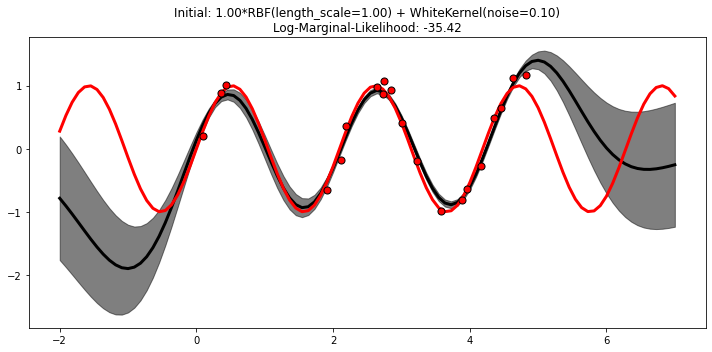

In [ ]:
title = ("Initial: {:1.2f}*RBF(length_scale={:1.2f}) + WhiteKernel(noise={:1.2f})\n"
         "Log-Marginal-Likelihood: {:1.2f}").format(sigma_f, length_scale, sigma, log_L) #1.2f 소수둘째자리까지 표현

show_gp_result(X, y, X_test, y_mean[:, 0], np.sqrt(np.diag(y_cov)), title)

# Using Library (without optimization)

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [ ]:
kernel = sigma_f * RBF(length_scale=length_scale) \
         + WhiteKernel(noise_level=sigma**2)
gp = GaussianProcessRegressor(kernel=kernel, optimizer=None).fit(X_, y_)

y_mean, y_cov = gp.predict(X_test_, return_cov=True)
print(y_mean.shape, y_cov.shape)

(100, 1) (100, 100)


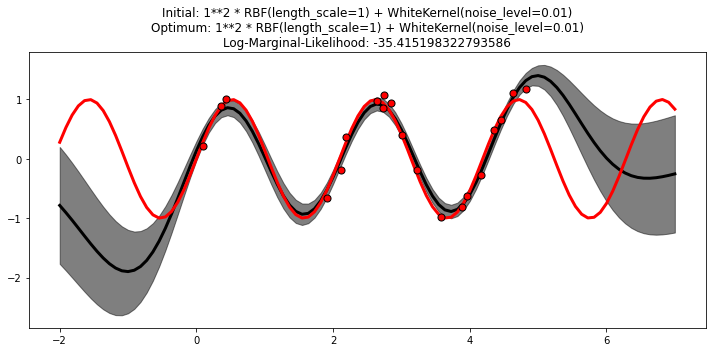

In [ ]:
title = "Initial: {}\nOptimum: {}\nLog-Marginal-Likelihood: {}".format(
    kernel, gp.kernel_, gp.log_marginal_likelihood(gp.kernel_.theta))

show_gp_result(X, y, X_test, y_mean[:, 0], np.sqrt(np.diag(y_cov)), title)

# Using Library (with optimization)

In [ ]:
# optimizer :  string or callable, optional (default: “fmin_l_bfgs_b”)
gp = GaussianProcessRegressor(kernel=kernel).fit(X_, y_)  

y_mean, y_cov = gp.predict(X_test_, return_cov=True)
print(y_mean.shape, y_cov.shape)

(100, 1) (100, 100)


### optimization 써야 Log-Marginal-Likelihood값이 커진다 (음수값임)

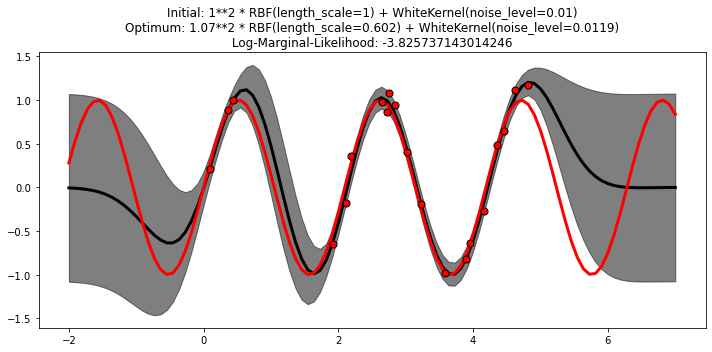

In [ ]:
title = "Initial: {}\nOptimum: {}\nLog-Marginal-Likelihood: {}".format(
    kernel, gp.kernel_, gp.log_marginal_likelihood(gp.kernel_.theta))

show_gp_result(X, y, X_test, y_mean[:, 0], np.sqrt(np.diag(y_cov)), title)

## Log-likelihood map

In [ ]:
from matplotlib.colors import LogNorm
# Plot LML landscape
theta0 = np.logspace(-1, 1, 49)
theta1 = np.logspace(-3, 0, 50)
Theta0, Theta1 = np.meshgrid(theta0, theta1)
LML = [[gp.log_marginal_likelihood(np.log([0.36, Theta0[i, j], Theta1[i, j]]))
        for i in range(Theta0.shape[0])] for j in range(Theta0.shape[1])]
LML = np.array(LML).T

vmin, vmax = (-LML).min(), (-LML).max()
vmax = 50
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), 50), decimals=1) #aound: 반올림, decimals=1: 소수점 첫째자리까지

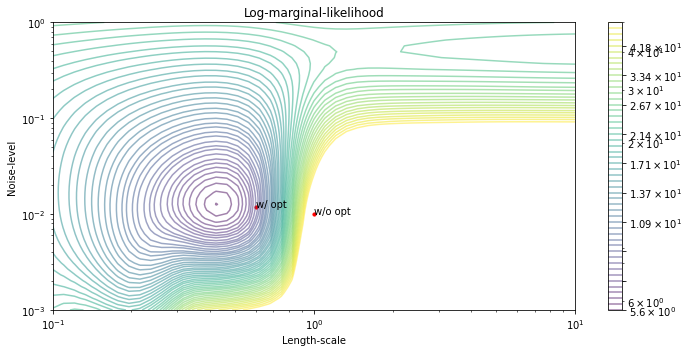

In [ ]:
fig = plt.figure(figsize=(10, 5))
#contour 등고선 플롯하기 

plt.contour(Theta0, Theta1, -LML,
            levels=level, norm=LogNorm(vmin=vmin, vmax=vmax), alpha=0.5) 
plt.colorbar()
plt.scatter(1, 0.01, 10, c='r')
plt.text(1, 0.01, 'w/o opt')
plt.scatter(np.exp(gp.kernel_.theta[1]), np.exp(gp.kernel_.theta[2]), 10, c='r')
plt.text(np.exp(gp.kernel_.theta[1]), np.exp(gp.kernel_.theta[2]), 'w/ opt') #lenth_scale, noise_level, log_marginal_likelihood
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Log-marginal-likelihood")
plt.tight_layout()


### 처음에 하이퍼파라미터를 입력해도 GP는 알아서 Log-marginal likelihood값을 최대로 하는 파라미터를 탐색한다.

### 하이퍼 파라미터를 자기가 알아서 찾아낸다

### log marginal likelihood map에서 모두 음수값이고 보라색이 될수록 값이 크다.  
그래서 원래 노란색쪽에 있던 (lengthscale,noise-level)값이 이동했다.

등고선이 좁을수록 가파르다